In [1]:
from mypulp import *
import numpy as np
import itertools
import networkx as nx
import math
import matplotlib.pyplot as plt
%matplotlib inline

# 巡回セールスマン問題

## 部分巡回路除去制約を逐次的に追加

In [2]:
def solve_tsp(V, d):
    model = Model('tsp')

    ## 変数 ##
    x = {}
    for i, j in itertools.product(V, V):
        if i < j:
            x[i, j] = model.addVar(vtype='B', name=f'x_{i},{j}')
    model.update()
    
    ## 定式化 ##
    for i in V:
        model.addConstr(quicksum(x[j, i] for j in V if j<i) + quicksum(x[i, j] for j in V if j>i) == 2)

    model.setObjective(quicksum(d[i, j] * x[i, j] for i in V for j in V if j>i), GRB.MINIMIZE)
    
    eps = 1.0e-6
    # 部分巡回路除去制約なしで最適化を行い，部分巡回路が発生したところに対して除去制約を追加して解いていく
    while True:
        model.optimize()
        
        G = nx.Graph()
        G.add_nodes_from(V)        
        
        # 得られた解のエッジ
        edges = []
        for i, j in x:
            if x[i, j].X > eps:
                edges.append([i, j])
        G.add_edges_from(edges)
        
        # 連結成分
        cc = list(nx.connected_components(G))  
        print(f'Number of subtours: {len(cc)} / ', end='')
        
        # 連結成分が1なら最適解が得られた
        # それ以外なら各連結成分に対して部分巡回路除去制約を追加
        if len(cc) == 1:
            break
        else:
            for S in cc:
                model.addConstr(quicksum(x[i, j] for i in S for j in S if j>i) <= len(S) - 1)
            model.update()

    model.__data = x
    
    return model, G

Number of subtours: 7 / Number of subtours: 9 / Number of subtours: 2 / Number of subtours: 3 / Number of subtours: 2 / Number of subtours: 1 / 
Optimal Value: 5949.147003376029


C:\Users\kengo\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


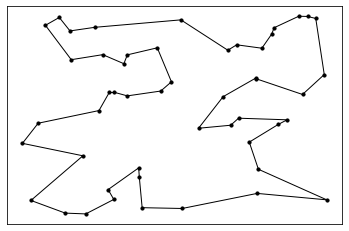

In [4]:
# n点からなるグラフの生成
n = 50
V = [i for i in range(n)]
#tours = nx.Graph()
#tours.add_nodes_from(V)

# 距離行列
np.random.seed(1234)
x = np.random.randint(low=0, high=1000, size=n)
y = np.random.randint(low=0, high=1000, size=n)
d = np.sqrt((x.reshape(-1,1) - x)**2 + (y.reshape(-1,1) - y)**2)  

p = {i: (x[i], y[i]) for i in range(n)}

model, G = solve_tsp(V, d)

print(f'\nOptimal Value: {model.ObjVal}')
nx.draw_networkx(G, pos=p, node_color='k', node_size=10, with_labels=False)
plt.show()

## MTZ制約

In [76]:
def solve_tsp_mtz(V, d):
    model = Model('tsp_mtz')

    ## 変数 ##
    x, u = {}, {}
    for i, j in itertools.product(V, V):
        if i != j:
            x[i, j] = model.addVar(vtype='B', name=f'x_{i},{j}')
    for i in V:
        u[i] = model.addVar(vtype='C', lb=0, ub=n-1, name=f'u_{i}')
    model.update()
    
    ## 定式化 ##
    for i in V:
        model.addConstr(quicksum(x[i, j] for j in V if j!=i) == 1)
        model.addConstr(quicksum(x[j, i] for j in V if j!=i) == 1)
        
        for j in range(1, n):
            if i != j:
                #model.addConstr(u[i] + 1 - (n-1)*(1-x[i, j]) <= u[j])
                model.addConstr(u[i] + 1 - (n-1)*(1-x[i, j]) + (n-3)*x[j, i] <= u[j])
    for i in range(1, n):
        model.addConstr(1 + (1-x[0, i]) + (n-3)*x[i, 0] <= u[i])
        model.addConstr(u[i] <= (n-1) - (1-x[i, 0] - (n-3)*x[0, i]))
    model.setObjective(quicksum(d[i, j] * x[i, j] for i, j in x), GRB.MINIMIZE)
    
    model.update()
    model.__data = x, u
    
    return model

Optimal Value: 3757.277080174551


C:\Users\kengo\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
C:\Users\kengo\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cb.iterable(node_size):  # many node sizes


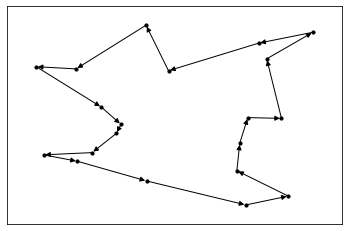

In [82]:
# n点からなるグラフの生成
n = 20
V = [i for i in range(n)]
#tours = nx.Graph()
#tours.add_nodes_from(V)

# 距離行列
np.random.seed(1234)
x = np.random.randint(low=0, high=1000, size=n)
y = np.random.randint(low=0, high=1000, size=n)
d = np.sqrt((x.reshape(-1,1) - x)**2 + (y.reshape(-1,1) - y)**2)  

p = {i: (x[i], y[i]) for i in range(n)}

model = solve_tsp_mtz(V, d)
model.optimize()
print(f'Optimal Value: {model.ObjVal}')

# 解の描画
x, u = model.__data
eps = 1.0e-6
optsol = []
for i, j in x:
    if x[i, j].X > eps:
        optsol.append([i, j])

G = nx.DiGraph()
G.add_nodes_from(V)
G.add_edges_from(optsol)
nx.draw_networkx(G, draw_arrows=True, pos=p, node_color='k', node_size=10, with_labels=False)
plt.show()

### 単一品種フロー定式化

In [33]:
def scf(n, d):
    model = Model('scf')

    ## 変数 ##
    x, f = {}, {}
    for i, j in itertools.product(range(n), range(n)):
        if i != j:
            x[i, j] = model.addVar(vtype='B', name=f'x_{i},{j}')
            if i == 0:
                f[i, j] = model.addVar(vtype='C', ub=np.float(n-1))
            else:
                f[i, j] = model.addVar(vtype='C', ub=np.float(n-2))
    model.update()
    
    ## 定式化 ##
    for i in range(n):
        model.addConstr(quicksum(x[i, j] for j in range(n) if j!=i) == 1)
        model.addConstr(quicksum(x[j, i] for j in range(n) if j!=i) == 1)
    
    model.addConstr(quicksum(f[0, j] for j in range(1, n)) == n - 1)

    for i in range(1, n):
        model.addConstr(quicksum(f[j, i] for j in range(n) if j!=i)
                        - quicksum(f[i, j] for j in range(n) if j!=i) == 1)

    for j in range(1, n):
        model.addConstr(f[0, j] <= (n-1)*x[0, j])
    for i in range(1, n):
        if i != j:
            model.addConstr(f[i, j] <= (n-2)*x[i, j])
    
    model.setObjective(quicksum(d[i, j] * x[i, j] for i, j in x), GRB.MINIMIZE)
    
    model.update()
    model.__data = x, f
    
    return model

Optimal Value: 2892.831414630052


C:\Users\kengo\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
C:\Users\kengo\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cb.iterable(node_size):  # many node sizes


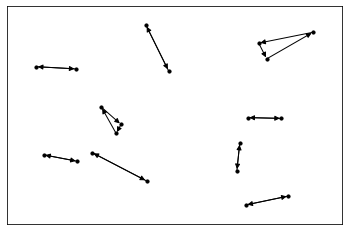

In [34]:
# n点からなるグラフの生成
n = 20
V = [i for i in range(n)]

# 距離行列
np.random.seed(1234)
x = np.random.randint(low=0, high=1000, size=n)
y = np.random.randint(low=0, high=1000, size=n)
d = np.sqrt((x.reshape(-1,1) - x)**2 + (y.reshape(-1,1) - y)**2)  

p = {i: (x[i], y[i]) for i in range(n)}

model = scf(n, d)
model.optimize()
print(f'Optimal Value: {model.ObjVal}')

# 解の描画
x, f = model.__data
eps = 1.0e-6
optsol = []
for i, j in x:
    if x[i, j].X > eps:
        optsol.append([i, j])

G = nx.DiGraph()
G.add_nodes_from(V)
G.add_edges_from(optsol)
nx.draw_networkx(G, draw_arrows=True, pos=p, node_color='k', node_size=10, with_labels=False)
plt.show()